In [1]:
%load_ext autoreload
%autoreload 2
import hdf5plugin # required to access LZ4-encoded HDF5 data sets
import matplotlib.pyplot as plt
from diffractem import io, tools, proc_peaks, version
from diffractem.dataset import Dataset
from diffractem.stream_parser import StreamParser
from diffractem import pre_process
import numpy as np
import pandas as pd
import os

opts = pre_process.PreProcOpts('preproc.yaml')
cfver = !{opts.im_exc} -v
print(f'Running on diffractem:', version())
print(f'Running on', cfver[0])
print(f'Current path is:', os.getcwd())

Running on diffractem: v0.2.1-52-g0d34dce
Running on CrystFEL: 0.8.0+f9101682
Current path is: /nas/processing/serialed/GV/publication


In [2]:
# Executor function for pre-processing steps.
# Change to adapt to your favorite parallelization scheme.
# This one is good if you have as many or more HDF5 files
# than CPU cores in your system.
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import dask
def execute(func, files):
    with ProcessPoolExecutor() as exc, dask.config.set(scheduler='single-threaded'):
        out = exc.map(func, files, repeat(opts))
        return [f[0] for f in out]

# Serial diffraction data preprocessing using _diffractem_
This notebook requires the diffractem package available from: 
https://github.com/robertbuecker/diffractem
It can be installed using pip: `pip install diffractem`.

Furthermore, a working installation of CrystFEL is required, available from:
http://www.desy.de/~twhite/crystfel/

Get example raw data from:
https://dx.doi.org/10.17617/3.2j

First, we have to make a list of raw files. `io.expand_files` can eiter using a list file, or explicit paths (including wildcards).

In [3]:
raw_files = io.expand_files('data/*.nxs')[:8]
print(f'Have {len(raw_files)} raw files. Have fun pre-processing!')

Have 8 raw files. Have fun pre-processing!


### Dataset initialization
pre_process.from_raw does the following:
* apply flat-field, saturation, and dead-pixel correction
* find the beam center using center of mass and fit of central peak
* shift the images accordingly
* write everything into new, renamed files

don't be irritated by occasional `RuntimeWarning`s from `scipy.optimize`.

The following options have an influence: reference, pxmask, correct_saturation, dead_time, shutter_time, float, cam_length, com_threshold, com_xrng, lorentz_radius, lorentz_maxshift, xsize, ysize, r_adf1, r_adf2, select_query, agg_query, aggregate, scratch_dir, proc_dir, rechunk

In [4]:
opts.load() # re-load option file
initial = execute(pre_process.from_raw, raw_files)

Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/map/features in Pandas/PyTables format
Found list /entry/map/features in Pandas/PyTables format
Found list /entry/map/features in Pandas/PyTables format
Found list /entry/map/feature

/opt/anaconda/envs/serialed/lib/python3.7/site-packages/scipy/optimize/minpack.py:449: RuntimeWarning: Number of calls to function has reached maxfev = 500.
  warnings.warn(errors[info][0], RuntimeWarning)


[21:01:11.064499 - GV_S11_008_00000.nxs - from_raw]  Finished first centering 178 shots after 138.44707894325256 seconds


/opt/anaconda/envs/serialed/lib/python3.7/site-packages/scipy/optimize/minpack.py:449: RuntimeWarning: Number of calls to function has reached maxfev = 500.
  warnings.warn(errors[info][0], RuntimeWarning)


[21:01:14.132211 - GV_S11_009_00000.nxs - from_raw]  Finished first centering 211 shots after 141.51425743103027 seconds
[21:02:46.544648 - GV_S11_004_00000.nxs - from_raw]  Finished first centering 346 shots after 233.92890405654907 seconds
[21:03:01.116148 - GV_S11_003_00000.nxs - from_raw]  Finished first centering 404 shots after 248.50097346305847 seconds
[21:03:06.356061 - GV_S11_007_00000.nxs - from_raw]  Finished first centering 400 shots after 253.7390420436859 seconds
[21:03:09.430620 - GV_S11_001_00000.nxs - from_raw]  Finished first centering 367 shots after 256.81595849990845 seconds
[21:04:09.713914 - GV_S11_005_00000.nxs - from_raw]  Finished first centering 588 shots after 317.0971086025238 seconds
[21:04:23.816727 - GV_S11_002_00000.nxs - from_raw]  Finished first centering 588 shots after 331.2015686035156 seconds


### A good time to optimize the peak finder
run this on a data sub-set, and look at the output stream: `edview.py agg_peaks.stream --internal`

Then, if required, tweak the `peak_search_params` settings in `preproc.yaml` until it looks something like:

![Nice peak finder result](doc/found_peaks.png "A good peakfinder result")

In [5]:
opts.load()
# we don't want to read the peaks into this workspace, so we set parse=False.
# Don't be irritated by 'waitpid() failed.' messages, that's ok.
pre_process.find_peaks(initial, opt=opts, stream_out='agg_peaks.stream', parse=False)

Indexing/integration disabled.
1571 images processed, 1421 hits (90.5%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals, 314.2 images/sec.
Waiting for the last patterns to be processed...
Final: 3082 images processed, 2769 hits (89.8%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals.



'agg_peaks.stream'

## Centering refinement
...based on matching of Friedel pairs present in a single image at low resolution (flat Ewald sphere of electrons!). Make sure that the peak finder works nicely _before_ running the refinement.

After calculating and storing the re-centered stack, the peak finding is automatically invoked, and the peaks are stored in the HDF5 files depending on how `peaks_cxi` and `peaks_nexus` are set in the options file. The former makes more sense, if you want to transfer the found peaks to other files later.

In [6]:
opts = pre_process.PreProcOpts('preproc.yaml')
refined = execute(pre_process.refine_center, initial)

Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Indexing/integration disabled.
205 images processed, 175 hits (85.4%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals, 41.0 images/sec.
Waiting for the last patterns to be processed...
353 images processed, 309 hits (87.5%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals, 29.6 images/sec.
Final: 367 images processed, 321 hits (87.5%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals.

Indexing/integration disabled.
0 images processed, 0 hits (-nan%), 0 indexable (-nan% of hits, -nan% overall), 0 crystals, 0.0 images/sec.
32 images processed, 27 hits (84.4%), 0 indexable (0.0% of hits, 0.0% overall), 0 crystals, 6.4 i

### Centering check
...to see if the centering worked as intended, and if everything is ready for indexing. Consider running it only for a sub-set by slicing `initial` and `refined` in the first two lines. In the first cell, you will get a histogram of the change in center along x and y. 

The second cell picks 4 random patterns, and shows the right half of them three times: (left) the pattern, (center) the pattern subtracted from itself rotated by 180 degrees before refinement, (right) the same after refinement. Bad centering will cause a "dipole" shape of mated Bragg peaks. You should see, that the Bragg peaks cancel each other nicely at the end (right panel). See green arrows below. It should look something like this:

![Centering](doc/centering.png "Centering worked well")

Don't be irritated if the central beam looks messier on the refined difference image, that's ok.

/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakTotalIntensity
  warn(f'Could not read stack {sn}')
/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakXPosRaw
  warn(f'Could not read stack {sn}')
/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakYPosRaw
  warn(f'Could not read stack {sn}')


79.7 % of shots were refined.


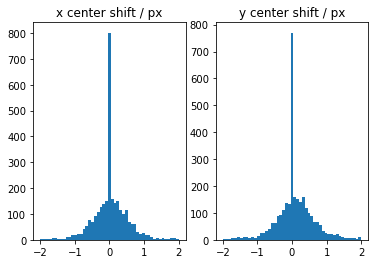

In [7]:
ds_original = Dataset.from_list(initial[:])
ds_refined = Dataset.from_list(refined[:])

with ds_original.Stacks() as stk_original, ds_refined.Stacks() as stk_refined:
    shifts = (ds_refined.beam_center - ds_original.beam_center).compute()

f, ax = plt.subplots(1,2)
ax[0].hist(shifts[:,0], bins=np.linspace(-2,2,50))
ax[0].set_title('x center shift / px')
ax[1].hist(shifts[:,1], bins=np.linspace(-2,2,50))
ax[1].set_title('y center shift / px');
print(np.round(sum(shifts[:,0] != 0)/len(shifts)*100,1), '% of shots were refined.')

/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakTotalIntensity
  warn(f'Could not read stack {sn}')
/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakXPosRaw
  warn(f'Could not read stack {sn}')
/opts/dev/diffractem/diffractem/dataset.py:731: UserWarning: Could not read stack peakYPosRaw
  warn(f'Could not read stack {sn}')


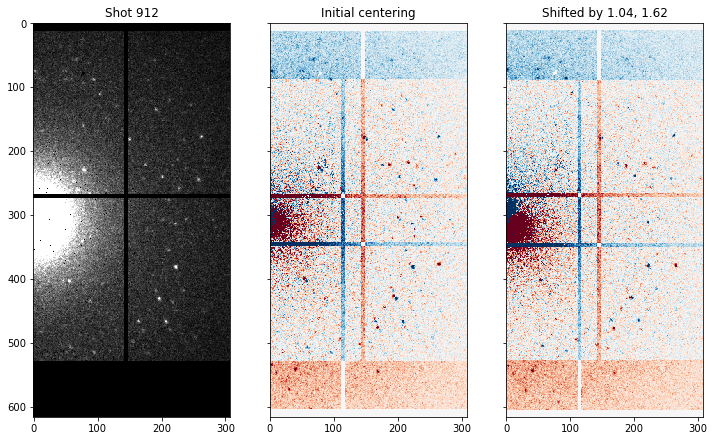

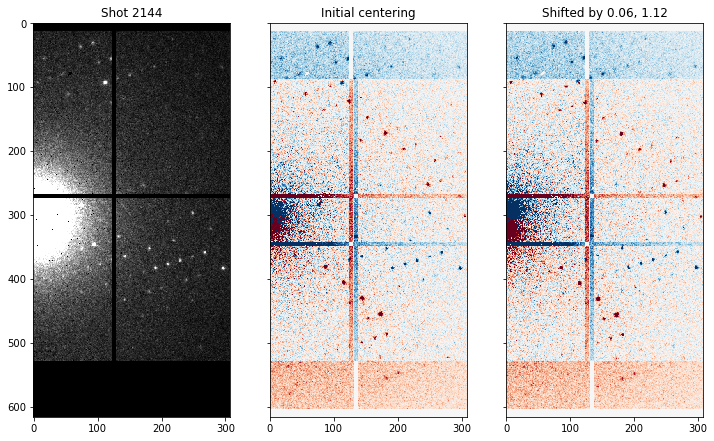

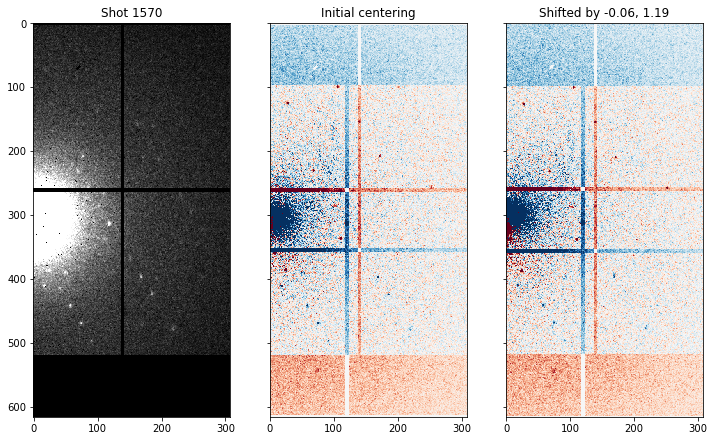

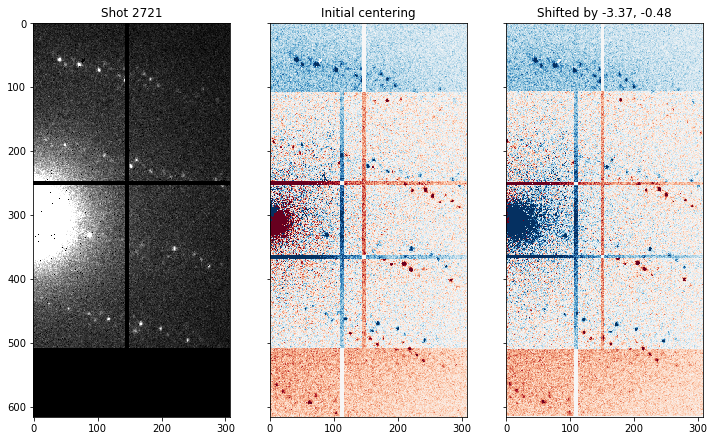

In [8]:
scale = 50 # change this to adjust contrast in the image

idcs = np.arange(len(shifts))[(np.abs(shifts[:,0]) > 1) | (np.abs(shifts[:,1]) > 1)]
idcs = idcs[np.random.randint(0,len(idcs),4)]
with ds_original.Stacks() as stk_original, ds_refined.Stacks() as stk_refined:
    imgs = stk_original['centered'][idcs,...].compute()
    imgs2 = stk_refined['centered'][idcs,...].compute()

%matplotlib inline
plt.close('all')

for img, img2, shift, idx in zip(imgs, imgs2, shifts[idcs,:], idcs):
    _, ax = plt.subplots(1,3, True, True,figsize=(12,12))
    ax[0].imshow(img[:,778:778+308], vmax=scale, cmap='gray')
    ax[1].imshow(((img-np.rot90(img,2)))[:,778:778+308], vmin=-scale/2, vmax=scale/2, cmap='RdBu')
    ax[2].imshow(((img2-np.rot90(img2,2)))[:,778:778+308], vmin=-scale/2, vmax=scale/2, cmap='RdBu')
    ax[0].set_title(f'Shot {idx}')
    ax[1].set_title(f'Initial centering')
    ax[2].set_title(f'Shifted by {shift[0]:.2f}, {shift[1]:.2f}')

## Ready for indexing, Preparation of sets for integration
Congratulations! Now you have a data set of diffraction patterns that have been summed over a certain number of fractionation frames (as defined in agg_query), that is intensity-corrected, well-centered, and ready for indexing in CrystFEL. See `indexing.ipynb`.

**However**, you should not want to stop pre-processing here! There is a whole lot more to do if you want to squeeze the best out of your data - note that all of it can be done in parallel to indexing:
* Apply pre-processing to _all_ single movie frames, instead of only the aggregated ones. This can be done much faster now using the `pre_process.broadcast` function, which reads the found peaks and beam centers from the just finished aggregated data sets and applies ('broadcasts') the results to each single movie frame.
* Apply background subtraction using `pre_process.subtract_bg`, to either the aggregated frames, or all frames (see step above). It does not help for indexing (unless you include some sort of post-refinement), but the extracted intensities will be significantly more accurate, as CrystFELs BG subtraction does not work particularly well for electron data.
* Once you have a set of _all_ movie frames, you can make one comprising _cumulative_ frames using `pre_process.cumulate`. In such a set, each stored pattern is a cumulative sum of patterns in that movie, i.e., corresponding to a different exposure time. These are the patterns you will want to base your final peak integration on, finding out which of the exposure times gives the best final result.

### Apply pre-processing to single frames
...using the knowledge gained from the aggregated ones. Important options are: select_query, single_suffix, idfields, broadcast_peaks

In [9]:
opts.load()
allshots = execute(pre_process.broadcast, refined)

Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found list /entry/data/shots in Pandas/PyTables format
Found

### Background subtraction
...applied to each single frame. Alternatively, you can also apply it to the aggregated set (created above) or the cumulative set (created below), but at this point it makes most sense (I think).

The way it works is:
- Find Bragg peaks (if `rerun_peak_finder: true`), or read them from the CXI fields in the files (if `rerun_peak_finder: false`), and label regions around them as invalid pixels. The region radius is set by `peak_radius` in the options.
- Create a radial profile by azimuthal averaging, excluding the peak regions, and apply a median filter to it with length `filter_len` (must be odd!).
- Calculate a background image from the radial profile, and subtract it from the original.

Unfortunately, this is still pretty slow, as the radial profile calculation is inefficient. To be optimized.

In [10]:
opts.load()
allshots_nobg = execute(pre_process.subtract_bg, allshots)

Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.


### Cumulation
Finally, datasets are created which contain 'cumulative' frames, that is, each frame holds the sum of all frames up to that point. An important setting is `cum_first_frame`, which allows to set the first frame from which cumulation starts, everything before is left as it is.

Say, you have an acquisition with 5 movie frames, then what you will get after `pre_process.cumulate` is:

| No. in stack       | 0 | 1   | 2     | 3     | 4     |
|--------------------|---|-----|-------|-------|-------|
| initial data       | 0 | 1   | 2     | 3     | 4     |
| cum_first_frame: 0 | 0 | 0+1 | 0...2 | 0...3 | 0...4 |
| cum_first_frame: 1 | 0 | 1   | 1+2   | 1...3 | 1...4 |
| cum_first_frame: 2 | 0 | 1   | 2     | 2+3   | 2...4 |

Usually, you'll want to keep `cum_first_frame: 0`, unless you have too much artifacts on the first frame.

In [11]:
opts.load()
cumulative = execute(pre_process.cumulate, allshots_nobg)

Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
Single-file dataset, disabling parallel I/O.
[21:57:56.236668 - GV_S11_008_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:56.270635 - GV_S11_009_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:56.673414 - GV_S11_004_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:56.763407 - GV_S11_003_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:56.763395 - GV_S11_007_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:56.810401 - GV_S11_001_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:57.291134 - GV_S11_005_00000_all_nobg.h5 - cumulate]  Cumulating from frame 0
[21:57:57.344629 - GV_S11_002_00000_all_nobg.

### Done!
If you've made it to here, you should have in your proc_data folder:
- ..._agg.h5: aggregated diffraction patterns (1 per feature/beam position), summed over a range of frames as defined in the `agg_query` parameter
- ..._agg_refined.h5: same, with refined beam center
- ..._all.h5: all diffraction patterns (N per feature/beam position, where N is the number of frames)
- ..._all_nobg.h5: same, with subtracted background
- ..._all_nobg_cumfrom0.h5: cumulative diffraction patterns (N per feature/beam position, with increasing effective exposure time)

The structure of all files is the same, and they can be read using the diffractem.Dataset class, or CrystFEL, or anything HDF5... just open it with hdfview to get an idea.